In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
%matplotlib inline
palette = 'muted'
sns.set_palette(palette)
sns.set_color_codes(palette)
np.set_printoptions(precision=2)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Simple example

In [16]:
clusters, n_cluster = 3, [90, 50, 75]
n_total = sum(n_cluster)
means, std_devs = [9, 21, 35], [2, 2, 2]

# print(n_total)
# print(len(np.repeat(means, n_cluster)))
# print(len(np.repeat(std_devs[0], n_total)))

mix = np.random.normal(np.repeat(means, n_cluster),
                       np.repeat(std_devs, n_cluster))


Text(0.5, 0, '$x$')

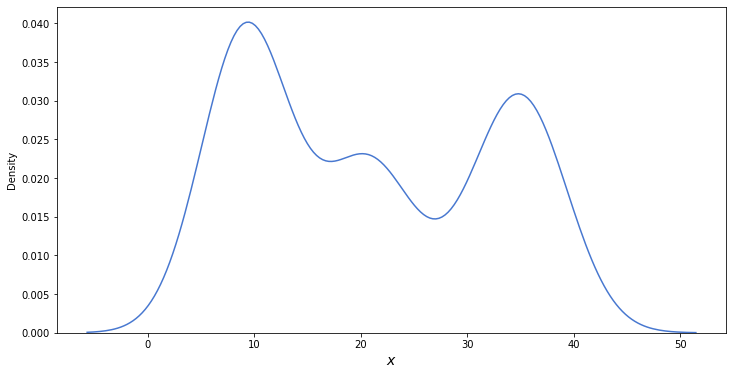

In [17]:
plt.figure(figsize=(12, 6))
sns.kdeplot(np.array(mix))
plt.xlabel('$x$', fontsize=14)

In [18]:
# Author: Thomas Boggs
import matplotlib.tri as tri
from functools import reduce
from matplotlib import ticker, cm

_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])
_midpoints = [(_corners[(i + 1) % 3] + _corners[(i + 2) % 3]) /
              2.0 for i in range(3)]


def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.
    Arguments:
        xy: A length-2 sequence containing the x and y value.
    '''
    s = [(_corners[i] - _midpoints[i]).dot(xy -
                                           _midpoints[i]) / 0.75 for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)


class Dirichlet(object):
    def __init__(self, alpha):
        '''Creates Dirichlet distribution with parameter `alpha`.'''
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
            reduce(mul, [gamma(a) for a in self._alpha])

    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa) in zip(x, self._alpha)])

    def sample(self, N):
        '''Generates a random sample of size `N`.'''
        return np.random.dirichlet(self._alpha, N)


def draw_pdf_contours(dist, nlevels=100, subdiv=8, **kwargs):
    '''Draws pdf contours over an equilateral triangle (2-simplex).
    Arguments:
        dist: A distribution instance with a `pdf` method.
        border (bool): If True, the simplex border is drawn.
        nlevels (int): Number of contours to draw.
        subdiv (int): Number of recursive mesh subdivisions to create.
        kwargs: Keyword args passed on to `plt.triplot`.
    '''
    refiner = tri.UniformTriRefiner(_triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap=cm.Blues, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')


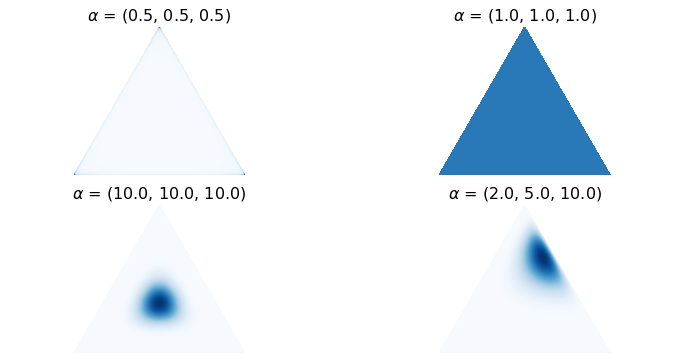

In [19]:
alphas = [[0.5] * 3, [1] * 3, [10] * 3, [2, 5, 10]]
plt.figure(figsize=(12, 6))
for (i, alpha) in enumerate(alphas):
    plt.subplot(2, 2, i + 1)
    dist = Dirichlet(alpha)
    draw_pdf_contours(dist)
    plt.title(r'$\alpha$ = ({:.1f}, {:.1f}, {:.1f})'.format(*alpha), fontsize=16)

In [20]:
with pm.Model() as model_kg:
    # Each observation is assigned to a cluster/component with probability p
    p = pm.Dirichlet('p', a=np.ones(clusters))
    category = pm.Categorical('category', p=p, shape=n_total) 
    
    # Known Gaussians means
    means = pm.math.constant([10, 20, 35])

    y = pm.Normal('y', mu=means[category], sd=2, observed=mix)

    step1 = pm.ElemwiseCategorical(vars=[category], values=range(clusters))
    ## The CategoricalGibbsMetropolis is a recent addition to PyMC3
    ## I have not find the time yet to experiment with it.
    #step1 = pm.CategoricalGibbsMetropolis(vars=[category]) 
    step2 = pm.Metropolis(vars=[p])
    trace_kg = pm.sampling.sample(10000, step=[step1, step2], return_inferencedata=False)

e:\Code\Algorithmic-Trading\env\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  # This is added back by InteractiveShellApp.init_path()
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>ElemwiseCategorical: [category]
>Metropolis: [p]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 88 seconds.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The number of effective samples is smaller than 10% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

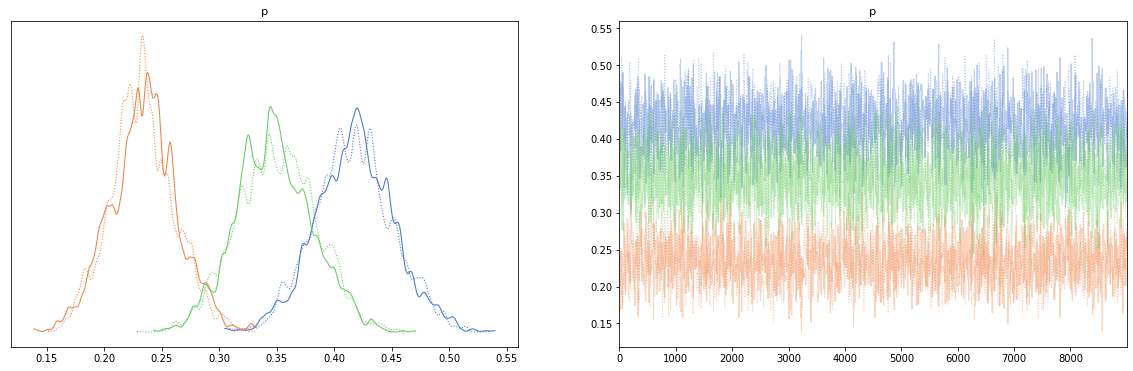

In [22]:
chain_kg = trace_kg[1000:]
varnames_kg = ['p']
pm.plot_trace(chain_kg, varnames_kg, figsize=(20, 6))

In [23]:
pm.summary(chain_kg, varnames_kg)

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[0],0.417,0.034,0.352,0.480,0.001,0.001,1776.0,1921.0,1.0
p[1],0.234,0.028,0.180,0.288,0.001,0.001,1599.0,2112.0,1.0
p[2],0.349,0.034,0.286,0.411,0.001,0.000,2368.0,2445.0,1.0


In [15]:
#krusckeplot

In [24]:
with pm.Model() as model_ug:
    # Each observation is assigned to a cluster/component with probability p
    p = pm.Dirichlet('p', a=np.ones(clusters))
    category = pm.Categorical('category', p=p, shape=n_total) 
    
    # We estimate the unknown gaussians means and standard deviation
    means = pm.Normal('means', mu=[10, 20, 35], sd=2, shape=clusters)
    sd = pm.HalfCauchy('sd', 5)

    y = pm.Normal('y', mu=means[category], sd=sd, observed=mix)

    step1 = pm.ElemwiseCategorical(vars=[category], values=range(clusters))
    step2 = pm.Metropolis(vars=[means, sd, p])
    
    trace_ug = pm.sampling.sample(10000, step=[step1, step2], return_inferencedata=False)

e:\Code\Algorithmic-Trading\env\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  if sys.path[0] == '':
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>ElemwiseCategorical: [category]
>CompoundStep
>>Metropolis: [p]
>>Metropolis: [sd]
>>Metropolis: [means]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 85 seconds.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The number of effective samples is smaller than 10% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'means'}>,
        <AxesSubplot:title={'center':'means'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

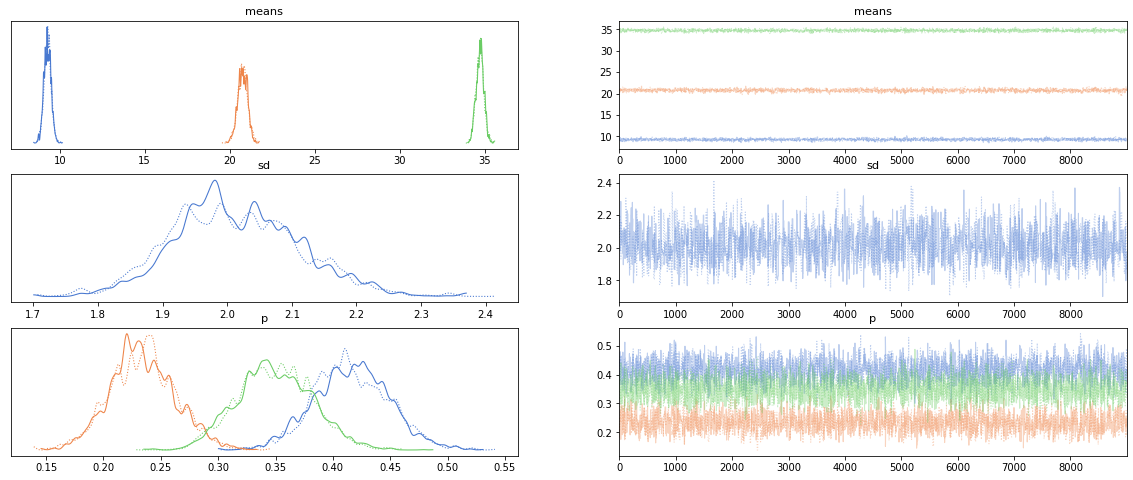

In [25]:
chain_ug = trace_ug[1000:]
varnames_ug = ['means', 'sd', 'p']
pm.plot_trace(chain_ug, varnames_ug, figsize=(20, 8))

In [26]:
pm.summary(chain_ug, varnames_ug)

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],9.281,0.208,8.904,9.680,0.005,0.004,1685.0,1874.0,1.0
means[1],20.756,0.289,20.206,21.294,0.008,0.006,1213.0,1876.0,1.0
means[2],34.718,0.230,34.290,35.141,0.006,0.004,1648.0,1891.0,1.0
sd,2.014,0.098,1.835,2.197,0.002,0.002,1588.0,1702.0,1.0
p[0],0.416,0.033,0.356,0.479,0.001,0.001,1987.0,2201.0,1.0
p[1],0.235,0.029,0.182,0.289,0.001,0.000,1651.0,2046.0,1.0
p[2],0.349,0.033,0.290,0.410,0.001,0.000,2508.0,2756.0,1.0


In [28]:
ppc = pm.sampling.sample_posterior_predictive(chain_ug, 50, model_ug)

e:\Code\Algorithmic-Trading\env\lib\site-packages\pymc3\sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


Text(0.5, 0, '$x$')

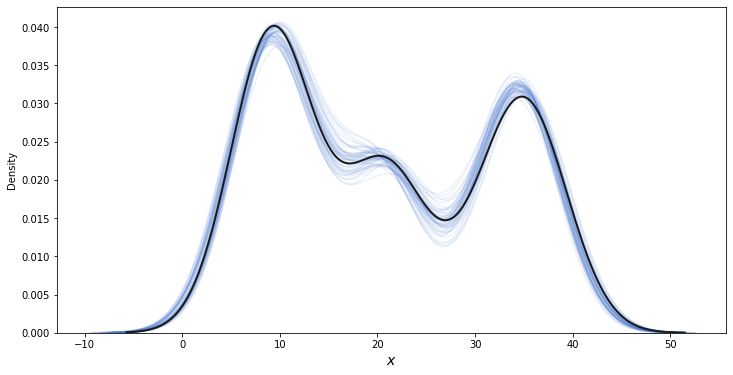

In [31]:
plt.figure(figsize=(12, 6))
for i in ppc['y']:
    sns.kdeplot(i, alpha=0.1, color='b')

sns.kdeplot(np.array(mix), lw=2, color='k') # you may want to replace this with the posterior mean
plt.xlabel('$x$', fontsize=14)

## Marginalized Gaussian Mixture model

In [32]:
with pm.Model() as model_mg:
    p = pm.Dirichlet('p', a=np.ones(clusters))

    means = pm.Normal('means', mu=[10, 20, 35], sd=2, shape=clusters)
    sd = pm.HalfCauchy('sd', 5)
    
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=mix)
    
    step = pm.Metropolis()
    trace_mg = pm.sampling.sample(5000, step, return_inferencedata=False)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sd]
>Metropolis: [means]
>Metropolis: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 38 seconds.
The number of effective samples is smaller than 10% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'means'}>,
        <AxesSubplot:title={'center':'means'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

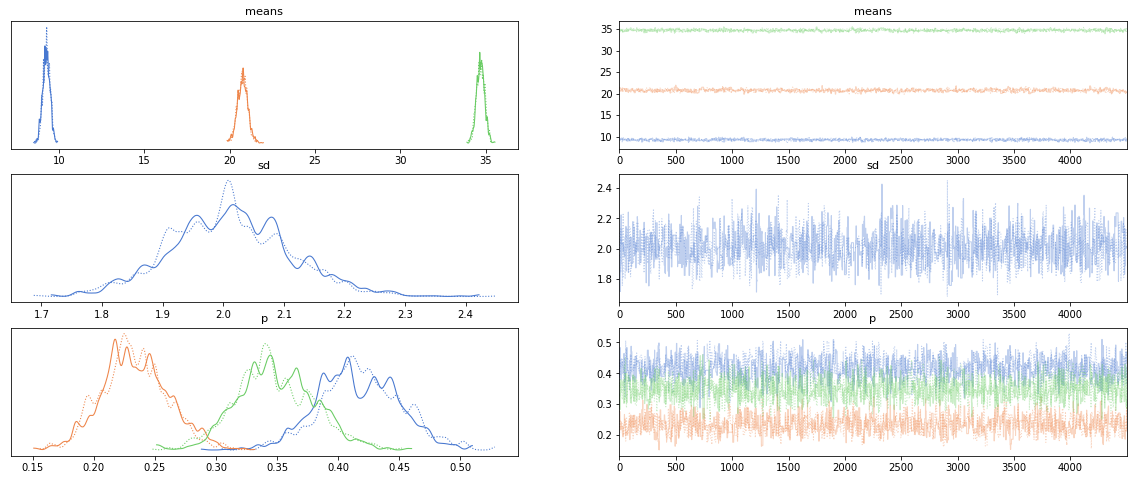

In [37]:
chain_mg = trace_mg[500:]
varnames_mg = ['means', 'sd', 'p']

# histogram or kernel density estimates
pm.plot_trace(chain_mg, varnames_mg, figsize=(20, 8))
# pm.plot_trace(chain_mg, varnames_mg, figsize=(20, 8), kind="rank_bars")
# pm.plot_trace(chain_mg, varnames_mg, figsize=(20, 8), compact=True)


## Zero inflated Poisson model

Text(0, 0.5, '$pmf(k)$')

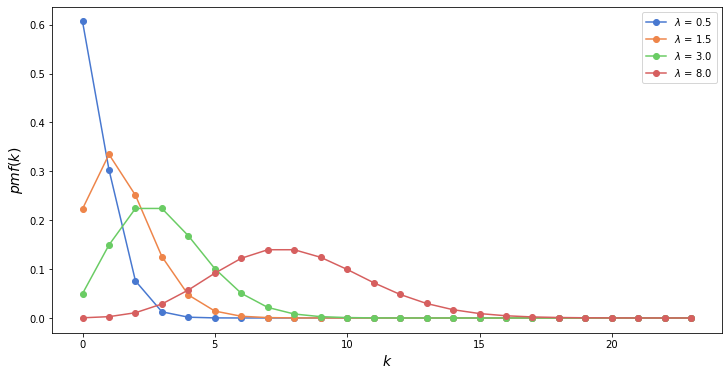

In [34]:
plt.figure(figsize=(12, 6))
lam_params = [0.5, 1.5, 3, 8]
k = np.arange(0, max(lam_params) * 3)

for lam in lam_params:
    y = stats.poisson(lam).pmf(k)
    plt.plot(k, y, 'o-', label="$\\lambda$ = {:3.1f}".format(lam))
plt.legend()
plt.xlabel('$k$', fontsize=14)
plt.ylabel('$pmf(k)$', fontsize=14)

In [46]:
np.random.seed(42)

# number , Poisson rate,  probability of extra-zeros (pi = 1-psi)
n, theta, pi = 100, 2.5, 0.1

# Simulate some data
counts = np.array([(np.random.random() > pi) * np.random.poisson(theta) for i in range(n)])

In [44]:
# plt.hist(counts, bins=30)

In [56]:
with pm.Model() as ZIP:
    psi = pm.Beta('psi', 1, 1)
    lam = pm.Gamma('lam', 2, 0.1)

    # https://discourse.pymc.io/t/zero-inflated-poisson-example/3862
    y = pm.ZeroInflatedPoisson('y', psi=psi, theta=lam,  observed=counts)
    trace_ZIP = pm.sampling.sample(5000, return_inferencedata=False)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam, psi]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 32 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'psi'}>,
        <AxesSubplot:title={'center':'psi'}>],
       [<AxesSubplot:title={'center':'lam'}>,
        <AxesSubplot:title={'center':'lam'}>]], dtype=object)

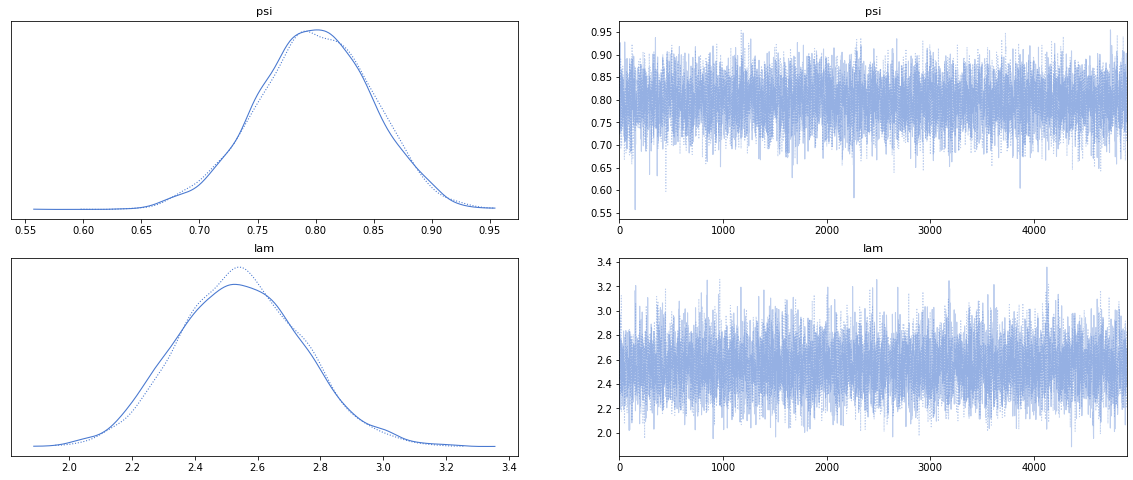

In [57]:
chain_ZIP = trace_ZIP[100:]
pm.plot_trace(chain_ZIP, figsize=(20, 8))

In [58]:
pm.summary(chain_ZIP)

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
psi,0.799,0.050,0.706,0.892,0.001,0.000,6471.0,5802.0,1.0
lam,2.546,0.199,2.170,2.913,0.003,0.002,5729.0,5905.0,1.0


## Zero inflated Poisson regression

In [60]:
# Kruschke plot
fish_data = pd.read_csv('fish.csv')
fish_data.head()

,nofish,livebait,camper,persons,child,xb,zg,count
0,1,0,0,1,0,-0.896315,3.050405,0
1,0,1,1,1,0,-0.558345,1.746149,0
2,0,1,0,1,0,-0.401731,0.279939,0
3,0,1,1,2,1,-0.956298,-0.601526,0
4,0,1,0,1,0,0.436891,0.527709,1


(array([228.,   8.,   6.,   1.,   4.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0.  ,   7.45,  14.9 ,  22.35,  29.8 ,  37.25,  44.7 ,  52.15,
         59.6 ,  67.05,  74.5 ,  81.95,  89.4 ,  96.85, 104.3 , 111.75,
        119.2 , 126.65, 134.1 , 141.55, 149.  ]),
 <BarContainer object of 20 artists>)

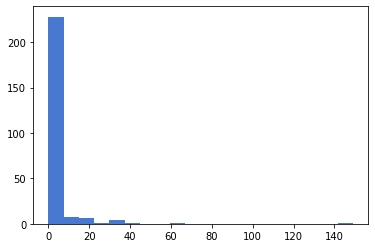

In [61]:
# plt.hist(fish_data['count'], bins=20)


In [62]:
with pm.Model() as ZIP_reg:
    psi = pm.Beta('psi', 1, 1)

    alpha = pm.Normal('alpha', 0, 10)
    beta = pm.Normal('beta', 0, 10, shape=2)
    lam = pm.math.exp(
        alpha + beta[0] * fish_data['child'] + beta[1] * fish_data['camper'])

    y = pm.ZeroInflatedPoisson(
        'y', psi=psi, theta=lam, observed=fish_data['count'])
    trace_ZIP_reg = pm.sampling.sample(2000, return_inferencedata=False)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, psi]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 35 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'psi'}>,
        <AxesSubplot:title={'center':'psi'}>]], dtype=object)

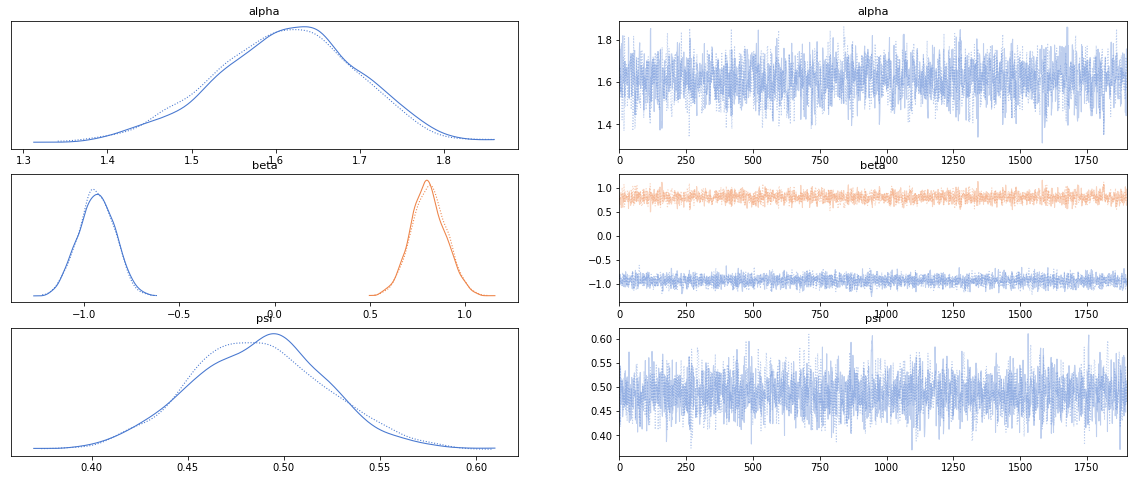

In [63]:
chain_ZIP_reg = trace_ZIP_reg[100:]
pm.plot_trace(chain_ZIP_reg, figsize=(20, 8))

In [64]:
pm.summary(chain_ZIP_reg)

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.612,0.085,1.456,1.771,0.002,0.001,1974.0,1776.0,1.0
beta[0],-0.935,0.095,-1.112,-0.762,0.002,0.001,2692.0,2119.0,1.0
beta[1],0.808,0.092,0.648,0.998,0.002,0.002,1950.0,1957.0,1.0
psi,0.487,0.036,0.422,0.557,0.001,0.001,2494.0,1921.0,1.0


In [65]:
children = [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []
thin = 5
for n in children:
    without_camper = chain_ZIP_reg['alpha'][::thin] + \
        chain_ZIP_reg['beta'][:, 0][::thin] * n
    with_camper = without_camper + chain_ZIP_reg['beta'][:, 1][::thin]
    fish_count_pred_0.append(np.exp(without_camper))
    fish_count_pred_1.append(np.exp(with_camper))

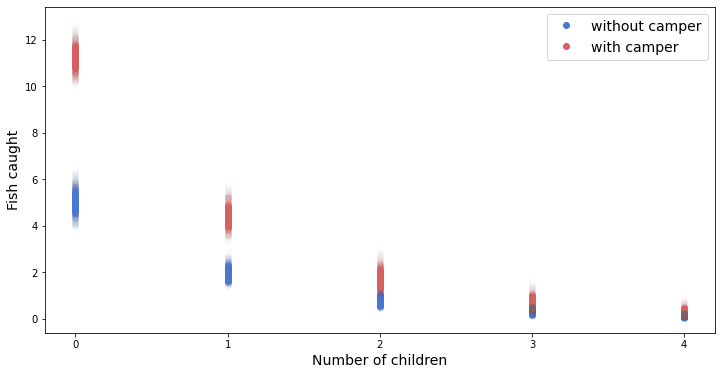

In [66]:
plt.figure(figsize=(12, 6))

plt.plot(children, fish_count_pred_0, 'bo', alpha=0.01)
plt.plot(children, fish_count_pred_1, 'ro', alpha=0.01)

plt.xticks(children)
plt.xlabel('Number of children', fontsize=14)
plt.ylabel('Fish caught', fontsize=14)
plt.plot([], 'bo', label='without camper')
plt.plot([], 'ro', label='with camper')
plt.legend(fontsize=14)

## Robust logistic Regression

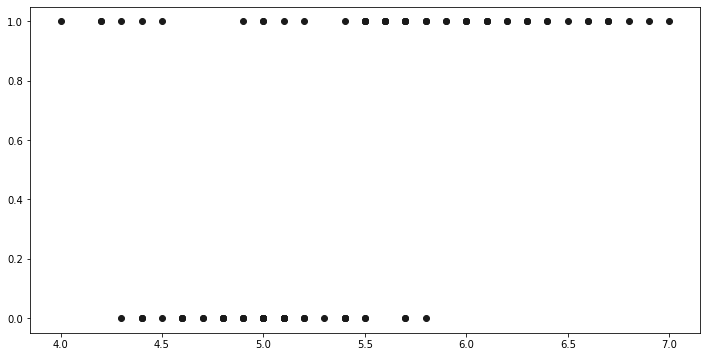

In [67]:
plt.figure(figsize=(12, 6))
iris = sns.load_dataset("iris")
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length'
x_0 = df[x_n].values
y_0 = np.concatenate((y_0, np.ones(6)))
x_0 = np.concatenate((x_0, [4.2, 4.5, 4.0, 4.3, 4.2, 4.4]))
x_0_m = x_0 - x_0.mean()
plt.plot(x_0, y_0, 'o', color='k')

In [68]:
with pm.Model() as model_rlg:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    mu = alpha_tmp + beta * x_0_m
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    pi = pm.Beta('pi', 1, 1)
    p = pi * 0.5 + (1 - pi) * theta
    
    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_0.mean())
    bd = pm.Deterministic('bd', -alpha/beta)
    
    yl = pm.Bernoulli('yl', p=p, observed=y_0)

    trace_rlg = pm.sampling.sample(2000, start=pm.find_MAP(), return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pi, beta, alpha_tmp]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 19 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.


Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'bd'}>,
        <AxesSubplot:title={'center':'bd'}>],
       [<AxesSubplot:title={'center':'pi'}>,
        <AxesSubplot:title={'center':'pi'}>]], dtype=object)

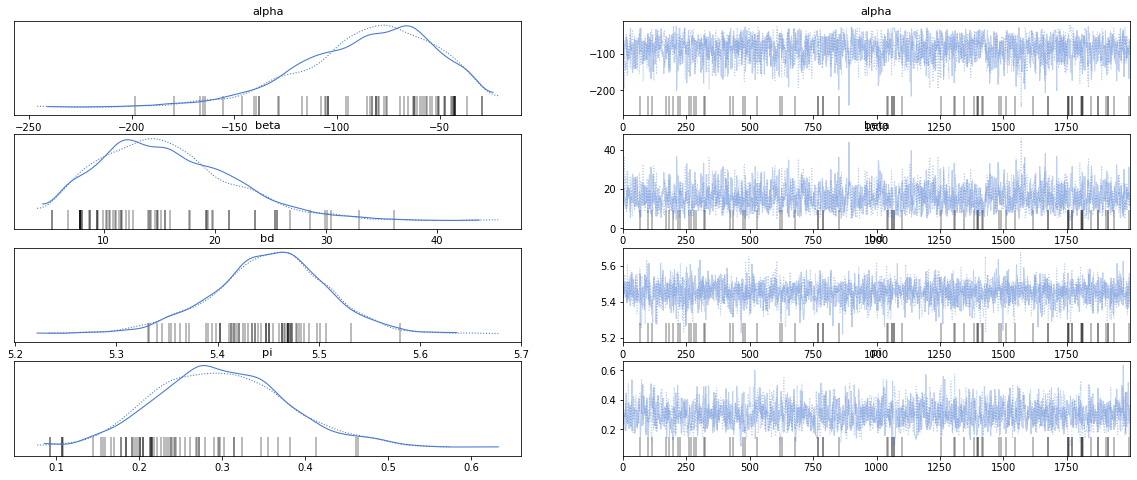

In [69]:
varnames = ['alpha', 'beta', 'bd', 'pi']
pm.plot_trace(trace_rlg, varnames, figsize=(20, 8))

In [41]:
pm.df_summary(trace_rlg, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-88.045398,32.057573,1.990573,-151.353483,-32.683495
beta,16.148924,5.867278,0.363771,6.209711,27.952638
bd,5.450774,0.054827,0.001557,5.338378,5.555840
pi,0.300405,0.075640,0.001696,0.154393,0.447944


e:\Code\Algorithmic-Trading\env\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  


Text(0, 0.5, '$\\theta$')

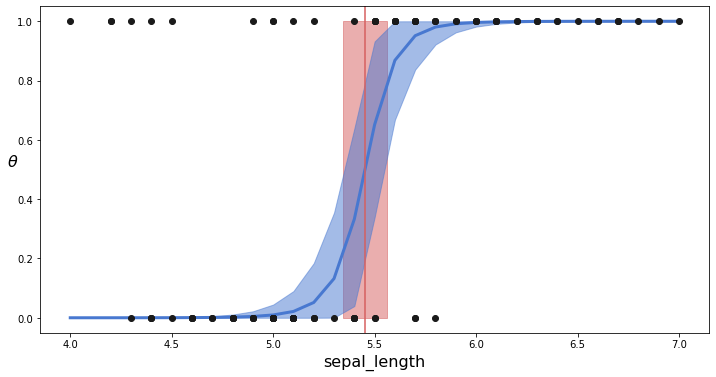

In [71]:
plt.figure(figsize=(12, 6))

theta = trace_rlg['theta'].mean(axis=0)
idx = np.argsort(x_0)

plt.plot(x_0[idx], theta[idx], color='b', lw=3)
plt.axvline(trace_rlg['bd'].mean(), ymax=1, color='r')

bd_hpd = az.hdi(trace_rlg['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)

plt.plot(x_0, y_0, 'o', color='k')

theta_hpd = az.hdi(trace_rlg['theta'])[idx]
plt.fill_between(x_0[idx], theta_hpd[:, 0],
                 theta_hpd[:, 1], color='b', alpha=0.5)

plt.xlabel(x_n, fontsize=16)
plt.ylabel('$\\theta$', rotation=0, fontsize=16)
